## Energy reconstruction after image classification

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

class CNN(torch.nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # input: (N,88,168,2)
            
            # conv: 2 -> 16 ch, 3x3 (stride-1)
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 16 -> 32 -> 32 ch, 3x3
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 32 -> 64 -> 64, 3x3
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 64 -> 128 -> 128 ch
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU(),
        )
        
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )
    
    def forward(self, x):
        net = self._feature(x)
        # average over spacial dimensions to flatten
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))

class CNNrec(torch.nn.Module):
    def __init__(self, num_out):
        super(CNNrec, self).__init__()
        
        # feature extractor
        self._feature = torch.nn.Sequential(
            # input: (N,88,168,2)
            
            # conv: 2 -> 16 ch, 3x3
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 16 -> 32 -> 32 ch, 3x3
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 32 -> 64 -> 64, 3x3
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 64 -> 128 -> 128 ch
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU(),
        )
        
        self._regressor = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_out)
        )
    
    def forward(self,x):
        net = self._feature(x)
        # average over spacial dimensions to flatten
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._regressor(net.view(-1,128))


class BLOB:
    pass

blob = BLOB()
blob.net = CNN(3).cuda()
blob.criterion = torch.nn.CrossEntropyLoss()
blob.optimizer = torch.optim.Adam(blob.net.parameters())
blob.softmax   = torch.nn.Softmax(dim=1)
blob.data      = None
blob.label     = None

def forward(blob,train=True):
    """
    Args: blob should have attributes: net, criterion, softmax, data, label
    Returns: a dictionary of predicted labels, softmax, loss and accuracy
    """
    with torch.set_grad_enabled(train):
        # prediction
        data = torch.as_tensor(blob.data).cuda()
        data = data.permute(0,3,1,2) # I think we bring the "channel" before the spacial dimension here
        prediction = blob.net(data)
        
        # training
        loss,acc = -1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()
            label.requires_grad = False # because we don't train this, sav space
            loss = blob.criterion(prediction,label) # evaluate loss function
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        prediction = prediction.cpu().detach().numpy()
        
        return {
            'prediction': prediction,
            'softmax':    softmax,
            'loss':       loss,
            'accuracy':   accuracy
        }

def backward(blob):
    blob.optimizer.zero_grad() # reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

    
# create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']

# for train
train_loader = loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)

# for validation
test_loader = loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.2, use_fraction=0.1)


from utils import progress_bar, CSVData
blob.train_log = CSVData('02-log_train.csv')
blob.test_log  = CSVData('02-log_test.csv')



TRAIN_EPOCH = 3.0 # one epoch is having processed all data once

blob.net.train()
epoch=0.
iteration=0

# start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
    # create progressbar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    for i,data in enumerate(train_loader):
        blob.data,blob.label = data[0:2]
        # make prediction and measure avg error
        res = forward(blob,train=True)
        # back-propopagate
        backward(blob)
        # epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        blob.iteration = iteration
        
        # log/report
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,train=False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train() # set back to training mode
        if (epoch >= TRAIN_EPOCH):
            break
    
    # final result of this epoch (not done yet)
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-04-16 22:17:52


Epoch 1 Starting @ 2019-04-16 22:19:08


Epoch 2 Starting @ 2019-04-16 22:20:25


In [4]:
blob.iteration = iteration

In [5]:
def save_state(blob, prefix='./snapshot'):
    # Output file name
    filename = '%s-%d.ckpt' % (prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(weight_file, blob):
    # Open a file in read-binary mode
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.iteration = checkpoint['global_step']

weight_file = save_state(blob, '04-imag-class')


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [6]:
blob.net.state_dict()

OrderedDict([('_feature.0.weight', tensor([[[[ 0.0265,  0.1024,  0.2149],
                        [ 0.3095,  0.2091, -0.0250],
                        [ 0.2971,  0.0139,  0.1849]],
              
                       [[ 0.1562, -0.0979, -0.0119],
                        [-0.0825, -0.0537,  0.1069],
                        [ 0.0684,  0.1204,  0.0418]]],
              
              
                      [[[ 0.1043,  0.2079, -0.0271],
                        [ 0.1989,  0.1094,  0.1957],
                        [ 0.1249, -0.0133,  0.0923]],
              
                       [[-0.0579, -0.0223, -0.0186],
                        [ 0.0614,  0.1144,  0.0849],
                        [ 0.0444,  0.0380,  0.1036]]],
              
              
                      [[[-0.1962,  0.0818, -0.1240],
                        [-0.2726, -0.0670,  0.2030],
                        [-0.0798, -0.1289,  0.2348]],
              
                       [[-0.1975, -0.1476, -0.0343],
                   

so the weights are saved as network name, then index in that network

In [8]:
blob_clas = blob

In [7]:
def forward(blob,train=True):
    """
    Args: blob should have net, criterion, softmax, data, truth
    Returns: a dictionary of reconstructed values, loss and mean_resolution
    """
    
    with torch.set_grad_enabled(train):
        # prediction
        data = torch.as_tensor(blob.data).cuda()
        data = data.permute(0,3,1,2) # I think we bring the "channel" before the spacial dimensions
        prediction = blob.net(data)
        
        # training
        loss,acc = -1,-1
        if blob.truth is not None:
            truth = torch.as_tensor(blob.truth).cuda()
            truth.requires_grad = False
            loss = blob.criterion(prediction,truth) # evaluate loss function
            # truth = F = 2.*sqrt(E)
            # E = F^2 / 4
            # dE/E = (1/2) F dF / (F^2/4) = 2 dF/F
            acc = 2.*torch.sqrt((prediction - truth)**2/truth**2).sum().item() / float(prediction.nelement())
        blob.loss = loss
        
        # I'll leave this softmax stuff out because for regression we don't have to make any decision
        prediction = prediction.cpu().detach().numpy()
        
        return {
            'prediction': prediction,
            'loss'      : loss,
            'mean_resolution': acc,
        }

def backward(blob):
    blob.optimizer.zero_grad() # reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


import h5py
from torch.utils.data import Dataset, DataLoader
import os

class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename. or None                                                                    
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        
        ret = {
            'event_data': fh['event_data'][entry_index],
            'labels':     fh['labels'][entry_index],
            'indices':    idx,
            'pids':       fh['pids'][entry_index],
            'energies':   fh['energies'][entry_index],
            'positions':  fh['positions'][entry_index],
            'directions': fh['directions'][entry_index],
        }
        
        if (len(ret['pids']) == 2):
            # 0 specifies axis
            ret['directions'] = np.array([(ret['positions'].T * ret['energies']).T.sum(0)/ret['energies'].sum()])
            
            ret['pids'] = np.array([ret['pids'].sum()]) # gives me 0 because e-:11, e+:-11
            ret['energies'] = np.array([ret['energies'].sum()])
            ret['positions'] = np.array([ret['positions'].sum(0)]) # 0 specifies axis
        
        return ret

def HKCollate(batch):
    ret = {}
    #print(batch)
    for key in batch[0].keys():
        ret[key] = [sample[key] for sample in batch]
    for key in ['event_data','pids','energies','positions','directions']:
        #print(key)
        ret[key] = np.stack(ret[key])
    return ret

def getTotalCharge(loader,loop_limit=100):
    B = loader.batch_size
    chg    = np.zeros(loop_limit*B)
    energy = np.zeros(loop_limit*B)
    labels = np.zeros(loop_limit*B)
    #print(energy[0:5].shape)
    
    for iteration, batch in enumerate(loader):
        idx = np.arange(iteration*B,(iteration+1)*B)
        if iteration == 0:
            print(chg[idx])
            print(batch['event_data'].shape)
            print('event_data.sum((1,2)).shape', batch['event_data'][:,:,:,0].sum((1,2)).shape)
            print('energies shape:',batch['energies'].shape)
            print('energies.reshape(-1) shape:',batch['energies'].reshape(-1).shape)
        chg[idx] = batch['event_data'][:,:,:,0].sum((1,2))
        energy[idx] = batch['energies'].reshape(-1)
        labels[idx] = batch['labels']

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return { 'charges': chg, 'energies': energy, 'labels': labels }

In [31]:
TRAIN_EPOCH = 3.0


blob = BLOB()
blob.net = CNNrec(1).cuda() # for now just energy
blob.criterion = torch.nn.MSELoss()
blob.optimizer = torch.optim.Adam(blob.net.parameters())
blob.data      = None
blob.truth     = None

In [14]:
DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']

train_loader = DataLoader(H5Dataset(DATA_DIRS,flavour='100k.h5',start_fraction=0.0, use_fraction=0.2),
                          batch_size=64,
                          shuffle=True,
                          num_workers=4,
                          collate_fn=HKCollate)
test_loader  = DataLoader(H5Dataset(DATA_DIRS,flavour='100k.h5',start_fraction=0.2, use_fraction=0.1),
                          batch_size=200,
                          shuffle=True,
                          num_workers=2,
                          collate_fn=HKCollate)

now load the weights from the classifier

In [32]:
# naiively restoring the whole network has issues because the output layer dimension of _feature is different
# restore_state(weight_file,blob)

with open(weight_file, 'rb') as f:
    # torch interprets the file, then we can access using string keys
    checkpoint = torch.load(f)
    # remove the problematic tensor
    for key in checkpoint['state_dict'].keys():
        if key.startswith('_classifier'):
            del checkpoint['state_dict'][key]
    
    # load network weights
    blob.net.load_state_dict(checkpoint['state_dict'], strict=False)

In [29]:
blob.net.state_dict()

OrderedDict([('_feature.0.weight', tensor([[[[ 0.0265,  0.1024,  0.2149],
                        [ 0.3095,  0.2091, -0.0250],
                        [ 0.2971,  0.0139,  0.1849]],
              
                       [[ 0.1562, -0.0979, -0.0119],
                        [-0.0825, -0.0537,  0.1069],
                        [ 0.0684,  0.1204,  0.0418]]],
              
              
                      [[[ 0.1043,  0.2079, -0.0271],
                        [ 0.1989,  0.1094,  0.1957],
                        [ 0.1249, -0.0133,  0.0923]],
              
                       [[-0.0579, -0.0223, -0.0186],
                        [ 0.0614,  0.1144,  0.0849],
                        [ 0.0444,  0.0380,  0.1036]]],
              
              
                      [[[-0.1962,  0.0818, -0.1240],
                        [-0.2726, -0.0670,  0.2030],
                        [-0.0798, -0.1289,  0.2348]],
              
                       [[-0.1975, -0.1476, -0.0343],
                   

In [33]:
blob.net.train() # set to training mode
blob.train_log = CSVData('04-rec-log_train.csv')
blob.test_log  = CSVData('04-rec-log_test.csv')

epoch = 0.
iteration = 0

# start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
    
    # create progressbar for *this* epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    for i,data in enumerate(train_loader):
        blob.data = data['event_data']
        blob.truth = 2.*np.sqrt(data['energies'].reshape(-1,1))
        res = forward(blob,train=True)
        backward(blob)
        epoch += 1./len(train_loader)
        iteration += 1
        
        # log/report
        blob.train_log.record(['iteration','epoch','mean_resolution','loss'], [iteration,epoch,res['mean_resolution'],res['loss']])
        blob.train_log.write()
        
        # once in a while, report
        if i%10 == 0:
            message = '... Iteration %d Epoch %1.2f ... Loss %1.3f ... Mean resolution %1.3f' % (iteration,epoch,res['loss'],res['mean_resolution'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        
        # more raretly, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval() # eval mode
                test_data = next(iter(test_loader))
                blob.data  = test_data['event_data']
                blob.truth = 2.*np.sqrt(test_data['energies'].reshape(-1,1))
                res = forward(blob,train=False)
                blob.test_log.record(['iteration','epoch','mean_resolution','loss'], [iteration,epoch,res['mean_resolution'],res['loss']])
                blob.test_log.write()
            blob.net.train() # training mode
        
        if (epoch >= TRAIN_EPOCH):
            break
    
    # final result of this epoch (not done yet)
    message = '... Iteration %d Epoch %1.2f ... Loss %1.3f ... Mean resolution %1.3f' % (iteration,epoch,res['loss'],res['mean_resolution'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-04-16 23:56:29


Epoch 1 Starting @ 2019-04-16 23:59:08


Epoch 2 Starting @ 2019-04-17 00:01:46


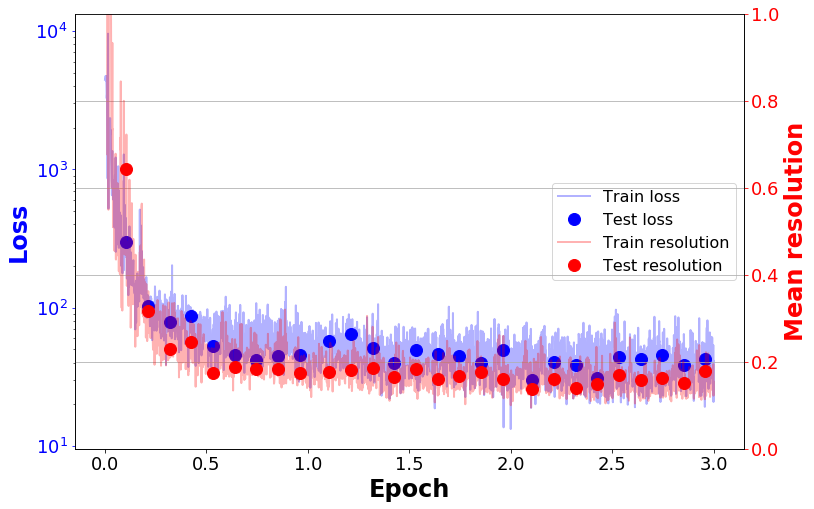

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8), facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch,  test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss',fontsize=24,fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
plt.yscale('log')

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.mean_resolution, linewidth=2, label='Train resolution', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch,  test_log.mean_resolution, marker='o', markersize=12, linestyle='', label='Test resolution', color='red')

ax2.set_ylabel('Mean resolution', fontsize=24, fontweight='bold', color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.)

lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

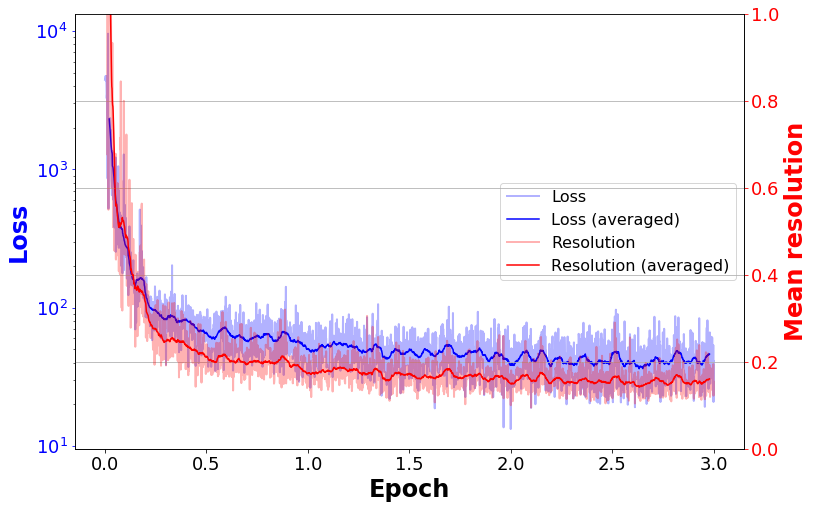

In [39]:
def moving_average(a,n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n-1):] / n

epoch    = moving_average(np.array(train_log.epoch),40)
meanres  = moving_average(np.array(train_log.mean_resolution),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8), facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss',fontsize=24,fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
plt.yscale('log')

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.mean_resolution, linewidth=2, label='Resolution', color='r', alpha=0.3)
line22 = ax2.plot(epoch, meanres, label='Resolution (averaged)', color='red')

ax2.set_ylabel('Mean resolution', fontsize=24, fontweight='bold', color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.)

lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [43]:
blob.net.eval() # eval mode

def resolutionPerEvent(loader,loop_limit=100):
    B = loader.batch_size
    chg    = np.zeros(loop_limit*B)
    energy = np.zeros(loop_limit*B)
    Erec   = np.zeros(loop_limit*B)
    labels = np.zeros(loop_limit*B)
    #print(energy[0:5].shape)
    
    for iteration, batch in enumerate(loader):
        idx = np.arange(iteration*B,(iteration+1)*B)
        if iteration == 0:
            print(chg[idx])
            print(batch['event_data'].shape)
            print('event_data.sum((1,2)).shape', batch['event_data'][:,:,:,0].sum((1,2)).shape)
            print('energies shape:',batch['energies'].shape)
            print('energies.reshape(-1) shape:',batch['energies'].reshape(-1).shape)
        chg[idx] = batch['event_data'][:,:,:,0].sum((1,2))
        energy[idx] = batch['energies'].reshape(-1)
        labels[idx] = batch['labels']
        
        blob.data  = batch['event_data']
        blob.truth = None
        res = forward(blob,train=False)
        Erec[idx] = (res['prediction'].reshape(-1)/2.)**2

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return { 'charges': chg, 'energies': energy, 'Erec': Erec, 'labels': labels }

resPerE = resolutionPerEvent(test_loader, 5)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
(200, 88, 168, 2)
event_data.sum((1,2)).shape (200,)
energies shape: (200, 1)
energies.reshape(-1) shape: (200,)


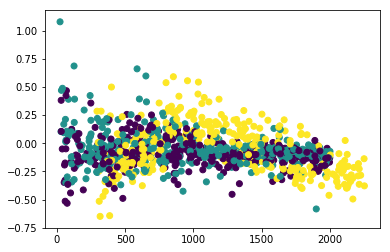

In [44]:
plt.scatter(resPerE['energies'], resPerE['Erec']/resPerE['energies'] - 1., c=resPerE['labels'])
plt.show()

In [46]:
blob.iteration = iteration
weight_file_reg = save_state(blob, '04-Ereg')

In [ ]:
# can we train further?

TRAIN_EPOCH = 10

train_loader = DataLoader(H5Dataset(DATA_DIRS,flavour='100k.h5',start_fraction=0.0, use_fraction=0.8),
                          batch_size=64,
                          shuffle=True,
                          num_workers=4,
                          collate_fn=HKCollate)
test_loader  = DataLoader(H5Dataset(DATA_DIRS,flavour='100k.h5',start_fraction=0.8, use_fraction=0.2),
                          batch_size=200,
                          shuffle=True,
                          num_workers=2,
                          collate_fn=HKCollate)

blob.net.train() # set to training mode
blob.train_log = CSVData('04-rec-log_train.csv')
blob.test_log  = CSVData('04-rec-log_test.csv')

epoch = 0.
iteration = 0

# start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
    
    # create progressbar for *this* epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    for i,data in enumerate(train_loader):
        blob.data = data['event_data']
        blob.truth = 2.*np.sqrt(data['energies'].reshape(-1,1))
        res = forward(blob,train=True)
        backward(blob)
        epoch += 1./len(train_loader)
        iteration += 1
        
        # log/report
        blob.train_log.record(['iteration','epoch','mean_resolution','loss'], [iteration,epoch,res['mean_resolution'],res['loss']])
        blob.train_log.write()
        
        # once in a while, report
        if i%10 == 0:
            message = '... Iteration %d Epoch %1.2f ... Loss %1.3f ... Mean resolution %1.3f' % (iteration,epoch,res['loss'],res['mean_resolution'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        
        # more raretly, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval() # eval mode
                test_data = next(iter(test_loader))
                blob.data  = test_data['event_data']
                blob.truth = 2.*np.sqrt(test_data['energies'].reshape(-1,1))
                res = forward(blob,train=False)
                blob.test_log.record(['iteration','epoch','mean_resolution','loss'], [iteration,epoch,res['mean_resolution'],res['loss']])
                blob.test_log.write()
            blob.net.train() # training mode
        
        if (epoch >= TRAIN_EPOCH):
            break
    
    # final result of this epoch (not done yet)
    message = '... Iteration %d Epoch %1.2f ... Loss %1.3f ... Mean resolution %1.3f' % (iteration,epoch,res['loss'],res['mean_resolution'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-04-17 08:08:22


Epoch 1 Starting @ 2019-04-17 08:15:42


Epoch 2 Starting @ 2019-04-17 08:25:27


Epoch 3 Starting @ 2019-04-17 08:32:23


In [52]:
blob.iteration = iteration
weight_file_reg = save_state(blob, '04-Ereg')

In [53]:
blob.net.eval() # eval mode

def resolutionPerEvent(loader,loop_limit=100):
    B = loader.batch_size
    chg    = np.zeros(loop_limit*B)
    energy = np.zeros(loop_limit*B)
    Erec   = np.zeros(loop_limit*B)
    labels = np.zeros(loop_limit*B)
    #print(energy[0:5].shape)
    
    for iteration, batch in enumerate(loader):
        idx = np.arange(iteration*B,(iteration+1)*B)
        if iteration == 0:
            print(chg[idx])
            print(batch['event_data'].shape)
            print('event_data.sum((1,2)).shape', batch['event_data'][:,:,:,0].sum((1,2)).shape)
            print('energies shape:',batch['energies'].shape)
            print('energies.reshape(-1) shape:',batch['energies'].reshape(-1).shape)
        chg[idx] = batch['event_data'][:,:,:,0].sum((1,2))
        energy[idx] = batch['energies'].reshape(-1)
        labels[idx] = batch['labels']
        
        blob.data  = batch['event_data']
        blob.truth = None
        res = forward(blob,train=False)
        Erec[idx] = (res['prediction'].reshape(-1)/2.)**2

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return { 'charges': chg, 'energies': energy, 'Erec': Erec, 'labels': labels }

resPerE = resolutionPerEvent(test_loader, 5)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
(200, 88, 168, 2)
event_data.sum((1,2)).shape (200,)
energies shape: (200, 1)
energies.reshape(-1) shape: (200,)


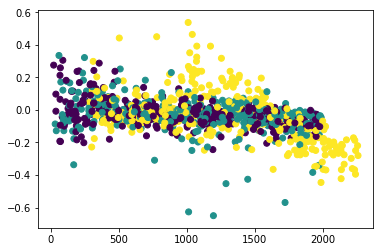

In [54]:
plt.scatter(resPerE['energies'], resPerE['Erec']/resPerE['energies'] - 1., c=resPerE['labels'])
plt.show()

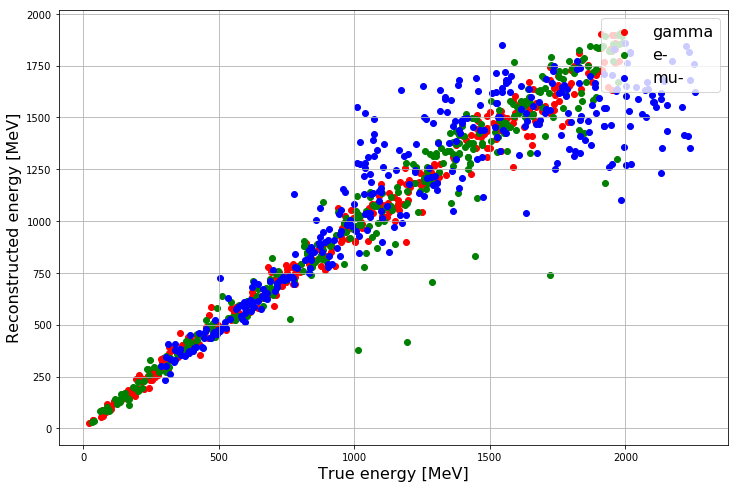

In [55]:
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
labname = ["gamma","e-","mu-"]
colors = ["red","green","blue"]

for lab in [0,1,2]:
    idx = np.where(resPerE['labels'] == lab)
    ax.scatter(resPerE['energies'][idx], resPerE['Erec'][idx], c=colors[lab], label=labname[lab])

ax.set_xlabel('True energy [MeV]',  fontsize=16)
ax.set_ylabel('Reconstructed energy [MeV]', fontsize=16)
#ax.tick_params('x',labelsize=20)
#ax.tick_params('y',labelsize=20)
ax.grid()

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()